In [1]:
!pip install tiktoken

In [2]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


Pre-Processing Dataset

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv(data_file_path, sep="\t",header=None,names=["Label","Text"])
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df["Label"].value_counts()

,count
Label,
ham,4825
spam,747


In [6]:
def create_balanced_dataset(df):
  """ Here it undersamples the ham dataset to create balanced dataset """
  num_spam = df[df["Label"] == "spam"].shape[0]

  ham_subset = df[df["Label"] == "ham"].sample(num_spam,random_state=123)

  balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

  return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [7]:
balanced_df["Label"] = balanced_df["Label"].map({"ham":0,"spam":1})

In [8]:
def random_split(df,train_frac,val_frac):
  """Performs test train split of the dataset
  """

  df = df.sample(frac=1,random_state=123).reset_index(drop=True)

  train_end = int(len(df) * train_frac)
  val_end = train_end + int(len(df)*val_frac)

  train_df = df[:train_end]
  val_df = df[train_end:val_end]
  test_df = df[val_end:]

  return train_df,val_df,test_df

train_df,val_df,test_df = random_split(balanced_df,0.7,0.1)

In [9]:
train_df.to_csv("train.csv",index=None)
val_df.to_csv("val.csv",index=None)
test_df.to_csv("test.csv",index=None)


Creating DataLoaders

In [10]:
import torch
from torch.utils.data import Dataset

In [11]:
class SpamDataset(Dataset):
  def __init__(self,csv_file,tokenizer,max_length=None,pad_token_id=50256):
    self.data = pd.read_csv(csv_file)

    self.encoded_texts = [
        tokenizer.encode(text) for text in self.data["Text"]
    ]

    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length

      # truncate if longer than max_length
      self.encoded_texts = [
          encoded_text[:self.max_length] for encoded_text in self.encoded_texts
      ]

    # pad

    self.encoded_texts = [
        encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts
    ]

  def __getitem__(self, index):
     encoded = self.encoded_texts[index]
     label = self.data.iloc[index]["Label"]

     return (
         torch.tensor(encoded,dtype=torch.long),
         torch.tensor(label,dtype=torch.long)
     )

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    max_length = 0
    for encoded_text in self.encoded_texts:
      encoded_length = len(encoded_text)
      if encoded_length > max_length:
        max_length = encoded_length

    return max_length

In [12]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [13]:
val_dataset = SpamDataset(
    csv_file="val.csv",
    max_length=train_dataset.max_length, # Or None
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length, # Or None
    tokenizer=tokenizer
)

In [14]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset = val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset = test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=False
)

In [15]:
#check

for input_batch, target_batch in train_loader:
  pass

input_batch.shape , target_batch.shape

(torch.Size([8, 120]), torch.Size([8]))

In [16]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


Model Setup

In [17]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size":50257,
    "context_length": 1024,
    "drop_rate":0.0,
    "qkv_bias":True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim":768, "n_layers":12,"n_heads":12}
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"],(
    f"Dataset length {train_dataset.max_length} exceeds model's context"
    f"length {BASE_CONFIG['context_length']}. Reinitializae data sets with max_lentgh = {BASE_CONFIG['context_length']}"
)

In [18]:
CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

'124M'

In [19]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")





In [20]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

prompt = "GPT2 is a model developed by OpenAI."

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

gen_tokens = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.9,
    max_length=100,
)
gen_text = tokenizer.batch_decode(gen_tokens)[0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [21]:
gen_text

'GPT2 is a model developed by OpenAI.\n\nThe researchers used a neural network to select and encode a single message from a 3D image, so that it could be read, written and played back. The resulting message was then encoded into a neural network, so that each cell could be read and written into a different cell. The neural network could then then generate a "code stream", which contained a code fragment containing all the data on the data line.\n\nAs a result'

In [22]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

###Adding Classification Head

Finetuning:


*   Final Output head
*   Final Transformer block
*   Final LayerNorm Module



In [23]:
for param in model.parameters():
  param.requires_grad=False # Freezing model parameters

In [24]:
# modifying output head
torch.manual_seed(123)

num_classes = 2
model.lm_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [25]:
model.lm_head

Linear(in_features=768, out_features=2, bias=True)

In [26]:
for param in model.transformer.h[-1].parameters():
  param.requires_grad = True

In [27]:
for param in model.transformer.ln_f.parameters():
  param.requires_grad = True

In [28]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=2, bias=True)
)

In [29]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

transformer.h.11.ln_1.weight
transformer.h.11.ln_1.bias
transformer.h.11.attn.c_attn.weight
transformer.h.11.attn.c_attn.bias
transformer.h.11.attn.c_proj.weight
transformer.h.11.attn.c_proj.bias
transformer.h.11.ln_2.weight
transformer.h.11.ln_2.bias
transformer.h.11.mlp.c_fc.weight
transformer.h.11.mlp.c_fc.bias
transformer.h.11.mlp.c_proj.weight
transformer.h.11.mlp.c_proj.bias
transformer.ln_f.weight
transformer.ln_f.bias
lm_head.weight
lm_head.bias


In [30]:
# Verification
model.eval()

dummy_input_ids = torch.randint(0, 50257, (1, 5))

with torch.no_grad():
    outputs = model(dummy_input_ids).logits  # Shape: (batch_size, seq_len, num_classes)

# Extract last token's logits
last_logits = outputs[:, -1, :]

print("Logits from last layer:", last_logits)
print("Shape of output logits:", last_logits.shape)  # Should be (1, 2)

Logits from last layer: tensor([[-4.4335,  5.3785]])
Shape of output logits: torch.Size([1, 2])


In [31]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
  model.eval()
  correct_predictions,num_examples = 0,0
  if num_batches is None:
    num_batches  = len(data_loader)

  else:
    num_batches = min(num_batches,len(data_loader))

  for i , (input_batch,target_batch) in enumerate(data_loader):
    if i < num_batches:
      input_batch, target_batch = input_batch.to(device), target_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch).logits[:, -1, :]
      predicted_labels = torch.argmax(logits, dim=-1)

      num_examples += predicted_labels.shape[0]
      correct_predictions += (predicted_labels == target_batch).sum().item()
    else:
      break

    return correct_predictions/num_examples


In [32]:
# Testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training Accuracy: {train_accuracy*100:.2f}")
print(f"Validation Accuracy: {val_accuracy*100:.2f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}")



Training Accuracy: 25.00
Validation Accuracy: 37.50
Test Accuracy: 37.50


In [33]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch).logits[:, -1, :]
  loss = torch.nn.functional.cross_entropy(logits,target_batch)
  return loss

In [34]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0

  if len(data_loader) == 0:
    return float("nan")

  elif num_batches is None:
    num_batches  = len(data_loader)

  else:
    num_batches = min(num_batches,len(data_loader))

  for i , (input_batch,target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch,target_batch,model,device)
      total_loss += loss.item()

    else:
      break

    return total_loss / num_batches


In [35]:
# Testing

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
  val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
  test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training Loss: {train_loss*100:.2f}")
print(f"Validation Loss: {val_loss*100:.2f}")
print(f"Test loss: {test_loss*100:.2f}")



Training Loss: 51.99
Validation Loss: 51.35
Test loss: 51.07


Finetuning Model

In [36]:
def train_classifier(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter):

  train_losses, val_losses, train_accs, val_accs = [],[],[],[]
  examples_seen,global_step = 0,-1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch,target_batch,model,device)
      loss.backward()
      optimizer.step()
      examples_seen += input_batch.shape[0]
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(
            model,train_loader,val_loader,device,eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch: {epoch+1} (Step: {global_step:06d}): Train Loss: {train_loss:.3f}, Validation Loss:{val_loss:.3f}")

    train_accuracy = calc_accuracy_loader(train_loader,model,device,num_batches=eval_iter)
    val_accuracy = calc_accuracy_loader(val_loader,model,device,num_batches=eval_iter)
    print(f"Training Accuracy: {train_accuracy*100:.2f}", end="")
    print(f"Validation Accuracy: {val_accuracy*100:.2f}")
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)

  return train_losses, val_losses, train_accs, val_accs, examples_seen


In [37]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader,model,device,num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

In [38]:
import time
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5,weight_decay=0.1)

num_epochs = 8
train_losses, val_losses, train_accs, val_accs,examples_seen = train_classifier(
    model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq=50,eval_iter=5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training Completed in {execution_time_minutes}")

Epoch: 1 (Step: 000000): Train Loss: 0.478, Validation Loss:0.716
Epoch: 1 (Step: 000050): Train Loss: 0.169, Validation Loss:0.156
Epoch: 1 (Step: 000100): Train Loss: 0.073, Validation Loss:0.153
Training Accuracy: 87.50Validation Accuracy: 75.00
Epoch: 2 (Step: 000150): Train Loss: 0.107, Validation Loss:0.145
Epoch: 2 (Step: 000200): Train Loss: 0.124, Validation Loss:0.175
Epoch: 2 (Step: 000250): Train Loss: 0.119, Validation Loss:0.096
Training Accuracy: 50.00Validation Accuracy: 62.50
Epoch: 3 (Step: 000300): Train Loss: 0.090, Validation Loss:0.070
Epoch: 3 (Step: 000350): Train Loss: 0.122, Validation Loss:0.082
Training Accuracy: 62.50Validation Accuracy: 87.50
Epoch: 4 (Step: 000400): Train Loss: 0.040, Validation Loss:0.114
Epoch: 4 (Step: 000450): Train Loss: 0.068, Validation Loss:0.098
Epoch: 4 (Step: 000500): Train Loss: 0.075, Validation Loss:0.108
Training Accuracy: 87.50Validation Accuracy: 75.00
Epoch: 5 (Step: 000550): Train Loss: 0.052, Validation Loss:0.092
Epoc

In [40]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

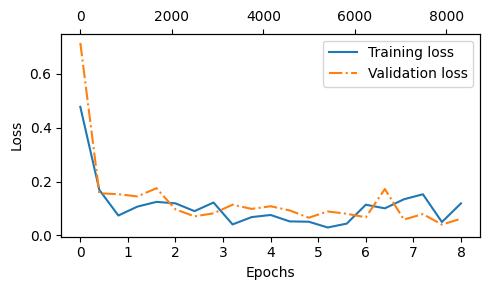

In [41]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

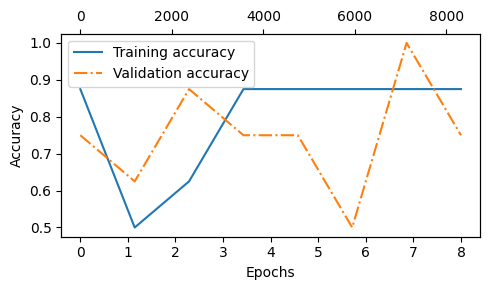

In [42]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [43]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 100.00%
Validation accuracy: 100.00%
Test accuracy: 75.00%


In [58]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.transformer.wpe.weight.shape[0]

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    with torch.no_grad():
        logits = model(input_tensor).logits[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [59]:
text_1 = "You are a winner you have been specially selected to receive Rs.100000 cash or a Rs.200000 award."

classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
)

'spam'

In [60]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [61]:
torch.save(model.state_dict(), "review_spam_classifier.pth")

In [62]:
# for loading saved model
model_state_dict = torch.load("review_spam_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>